# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Introduction: Business Problem
In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **restaurant and school** in **New York**, Unite States.

Since there are lots of restaurants in **New York** we will try to detect **locations that are not already crowded with restaurants**. We choose some candidate location in Queens New York city. We want to get the cluster information about the Center Queens, so that we can analyze the cluster. Secondly, it is important that analyze the distribution of the **restaurant type** in each cluster.

We will use our data science powers to generate a few most promising neighborhoods based on this criteria. Advantages of each area will then be clearly expressed and get the cluster character, so that best possible final location and restaurant type can be chosen by stakeholders.So, we want to explore the center candidate location that belongs to the restaurant type.

## Data
Based on definition of our problem, factors that will influence our decision are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of and distance to Italian restaurants in the neighborhood, if any
* distance of neighborhood from city center
* number of school in the neighborhood (any type of school)

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Google Maps API reverse geocoding**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* number of schools and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of New York center will be obtained using **MapBox API** of well known New York Queens location

## Neighborhood Candidates
Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which is aprox. 12x12 killometers centered around Berlin city center.

Let's first find the latitude & longitude of Queens New York city center, using specific, well known address and Google Maps geocoding API.

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from matplotlib import  pyplot as plt
import requests
import folium
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import json
import seaborn as sns
%matplotlib inline

In [2]:
if False:
    df = pd.read_csv("./data/data.csv")

## create a geolocator object for each city

In [3]:
# The code was removed by Watson Studio for sharing.
google_api_key = ""

In [4]:
def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]
    
address = "Queens, New York, United States"
center = get_coordinates(google_api_key, address)
print('Coordinate of {}: {}'.format(address, center))

Coordinate of Queens, New York, United States: [40.7282239, -73.7948516]


In [ ]:
# !pip install shapely
# !pip install pyproj

In [5]:
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('Queens center longitude={}, latitude={}'.format(center[1], center[0]))
x, y = lonlat_to_xy(center[1], center[0])
print('Queens center UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('Queens center longitude={}, latitude={}'.format(lo, la))

Coordinate transformation check
-------------------------------
Queens center longitude=-73.7948516, latitude=40.7282239
Queens center UTM X=-5818864.983873131, Y=9842433.386218188
Queens center longitude=-73.79485159999955, latitude=40.728223899998895


Next step, let's create a hexagonal grid of cells: we offset every other row, and adjust vertical row spacing so that every cell center is equally distant from all it's neighbors. Besides, let's visualize the data we have so far: city center location and candidate neighborhood centers.

Now let's create a grid of area candidates, same spaced, centered around city center and within ~6km from Queens. Our neighborhoods will be defined as circular areas with a radius of 300 meters, so our neighborhood centers will be 600 meters apart.

To accurately calculate distances we need to create our grid of locations in Cartesian 2D coordinate system which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in meters).

In [6]:
center_x, center_y = lonlat_to_xy(center[1], center[0]) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = center_x - 6000
x_step = 600
y_min = center_y - 6000 - (int(21/k)*k*600 - 12000)/2
y_step = 600 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = 300 if i%2==0 else 0
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(center_x, center_y, x, y)
        if (distance_from_center <= 6001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

364 candidate neighborhood centers generated.


In [7]:
#!pip install folium

import folium

In [ ]:
map_init = folium.Map(location=center, zoom_start=13)
folium.Marker(center, popup='Queens').add_to(map_init)
for lat, lon in zip(latitudes, longitudes):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_init)
    #folium.Marker([lat, lon]).add_to(map_berlin)
map_init


In [8]:
def get_address(api_key, latitude, longitude, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&latlng={},{}'.format(api_key, latitude, longitude)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        address = results[0]['formatted_address']
        return address
    except:
        return None

addr = get_address(google_api_key, center[0], center[1])
print('Reverse geocoding check')
print('-----------------------')
print('Address of [{}, {}] is: {}'.format(center[0], center[1], addr))

Reverse geocoding check
-----------------------
Address of [40.7282239, -73.7948516] is: Virginia Cheriton, Fresh Meadows, NY 11366, USA


In [9]:
print('Obtaining location addresses: ', end='')
addresses = []
cou = 0
for lat, lon in zip(latitudes, longitudes):
    address = get_address(google_api_key, lat, lon)
    if address is None:
        address = 'NO ADDRESS'
    address = address.replace(', USA', '') # We don't need country part of address
    addresses.append(address)
    print(' .', end='')
    if cou > 5:
        break
    cou += 1
print(' done.')

Obtaining location addresses:  . . . . . . . done.


In [14]:
pd.DataFrame({'Address': addresses,
                             'Latitude': latitudes[:len(addresses)],
                             'Longitude': longitudes[:len(addresses)],
                             'X': xs[:len(addresses)],
                             'Y': ys[:len(addresses)],
                             'Distance from center': distances_from_center[:len(addresses)]})

,Address,Latitude,Longitude,X,Y,Distance from center
0,"93-46 210th Pl, Queens Village, NY 11428",40.716520,-73.751049,-5.820665e+06,9.836718e+06,5992.495307
1,"211-30 90th Ct, Jamaica, NY 11428",40.720054,-73.750895,-5.820065e+06,9.836718e+06,5840.376700
2,"89-28 213th St, Queens Village, NY 11427",40.723589,-73.750740,-5.819465e+06,9.836718e+06,5747.173218
3,"214-46 Whitehall Terrace, Jamaica, NY 11427",40.727124,-73.750586,-5.818865e+06,9.836718e+06,5715.767665
4,"218-17 Grand Central Pkwy, Jamaica, NY 11427",40.730659,-73.750431,-5.818265e+06,9.836718e+06,5747.173218
5,"220-24 Hartland Ave, Jamaica, NY 11427",40.734194,-73.750276,-5.817665e+06,9.836718e+06,5840.376700
6,"220-72 77th Ave, Flushing, NY 11364",40.737730,-73.750122,-5.817065e+06,9.836718e+06,5992.495307


In [ ]:
df = pd.DataFrame({'Address': addresses,
                             'Latitude': latitudes,
                             'Longitude': longitudes,
                             'X': xs,
                             'Y': ys,
                             'Distance from center': distances_from_center})

df.head(10)

## Get Food Category And School Information

Get the food category and the school information about Queens center by using FourSquare API. 

In [15]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
CLIENT_ID = ""
CLIENT_SECRET = ""
VERSION = '20181020'
categoryFood = "4d4b7105d754a06374d81259"
categorySchool = "4bf58dd8d48988d13d941735"

In [16]:
def getNearbyVenues(name, latitude, longitude, radius=2000, category=""):
    url = 'https://api.foursquare.com/v2/venues/search?&radius={}&'.format(radius)
    expand_infor = "client_id={}&client_secret={}&v={}&ll={},{}&limit={}".format(
        CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, LIMIT
    )
    
    if category:
        category_infor = "&categoryId={}".format(category)
    else:
        category_infor = ""
    # merge the url
    url = url + expand_infor + category_infor
    
    
    # extract infromation
    response = requests.get(url).json()
    
    return response

In [ ]:
# use the api to get category food
df["CategoryFood"] = df.apply(lambda x: getNearbyVenues(
        x["Address"], x["Latitude"], x["Longitude"], category=categoryFood
    ), axis=1)

In [ ]:
# use the api to get school infor
df["CategorySchool"] = df.apply(lambda x: getNearbyVenues(
        x["Address"], x["Latitude"], x["Longitude"], category=categorySchool
    ), axis=1)

## Parse School Information & Food Information

Next step, we want get the number of food category and the number of school

In [20]:
def get_category(x, target="category"):
    """
    parameters:
    ----------
    target: string, default category
        Choose target information. Like category, name, location
    """
    information = dict(
        Name = [],
        Location = [],
        Category = []
        )
    x = json.loads(x)
    if "response" not in x or "venues" not in x["response"]:
        return np.nan
    for item in x["response"]["venues"]:
        name = item["name"]
        location = (item["location"]["lat"], item["location"]["lng"])
        category = item["categories"][0]["name"]
        
        if name and location and category:
            information["Name"].append(name)
            information["Location"].append(location)
            information["Category"].append(category)
    if target == "category":
        return information["Category"]
    elif target == "name":
        return information["Name"]
    elif target == "location":
        return information["Location"]
    elif target in ["all", ""]:
        return information

In [21]:
df["FoodInformation"] = df.CategoryFood.apply(get_category, target="all")
df["SchoolInformation"] = df.CategorySchool.apply(get_category, target="all")

In [22]:
df.head(2)

,Address,Latitude,Longitude,X,Y,Distance from center,CategoryFood,CategorySchool,FoodInformation,SchoolInformation,...,Vegetarian / Vegan Restaurant,New American Restaurant,Chinese Restaurant,Tapas Restaurant,Indian Restaurant,Dumpling Restaurant,Halal Restaurant,High School,Elementary School,Szechuan Restaurant
0,"93-46 210th Pl, Queens Village, NY 11428",40.716520,-73.751049,-5.820665e+06,9.836718e+06,5992.495307,"{""meta"": {""code"": 200, ""requestId"": ""5cb1bc00f...","{""meta"": {""code"": 200, ""requestId"": ""5caa2f4cd...","{'Name': ['Dunkin'', 'Dunkin' Donuts/Baskin Ro...","{'Name': ['Queens Satellite Highschool', 'Path...",...,0,0,5,0,0,0,0,8,0,0
1,"211-30 90th Ct, Jamaica, NY 11428",40.720054,-73.750895,-5.820065e+06,9.836718e+06,5840.376700,"{""meta"": {""code"": 200, ""requestId"": ""5cb1bc00d...","{""meta"": {""code"": 200, ""requestId"": ""5caa2f4dd...","{'Name': ['Baskin Robbins', 'Dunkin' Donuts/Ba...","{'Name': ['Queens Satellite Highschool', 'Path...",...,0,0,4,0,0,0,1,7,0,0


In [24]:
foodtype = set()
for i in df.FoodInformation:
    if pd.notna(i):
        try:
            i = json.loads(i)
        except:
            foodtype.update(set(i["Category"]))

In [26]:
foodtype = pd.Series(list(foodtype))
for column in foodtype[foodtype.str.contains("Restaurant", case=False)]:
    try:
        df[column] = df.FoodInformation.apply(json.loads).apply(lambda x: x["Category"].count(column) 
                                                            if pd.notna(x) else 0)
    except:
        df[column] = df.FoodInformation.apply(lambda x: x["Category"].count(column) 
                                                            if pd.notna(x) else 0)

In [27]:
schooltype = set()
for i in df.SchoolInformation:
    if pd.notna(i):
        try:
            i = json.loads(i)
            schooltype.update(set(i["Category"]))
        except:
            schooltype.update(set(i["Category"]))

In [28]:
schooltype = pd.Series(list(schooltype))
for column in schooltype[schooltype.str.contains("College|Elementary|School|University", case=False)]:
    try:
        df[column] = df.SchoolInformation.apply(json.loads).apply(lambda x: 
                                                                  x["Category"].count(column) if pd.notna(x) else 0)
    except:
        df[column] = df.SchoolInformation.apply(lambda x: x["Category"].count(column) if pd.notna(x) else 0)

In [29]:
schooltype

0          High School
1    Elementary School
2            Cafeteria
dtype: object

In [30]:
df.head(2)

,Address,Latitude,Longitude,X,Y,Distance from center,CategoryFood,CategorySchool,FoodInformation,SchoolInformation,...,Vegetarian / Vegan Restaurant,New American Restaurant,Chinese Restaurant,Tapas Restaurant,Indian Restaurant,Dumpling Restaurant,Halal Restaurant,High School,Elementary School,Szechuan Restaurant
0,"93-46 210th Pl, Queens Village, NY 11428",40.716520,-73.751049,-5.820665e+06,9.836718e+06,5992.495307,"{""meta"": {""code"": 200, ""requestId"": ""5cb1bc00f...","{""meta"": {""code"": 200, ""requestId"": ""5caa2f4cd...","{'Name': ['Dunkin'', 'Dunkin' Donuts/Baskin Ro...","{'Name': ['Queens Satellite Highschool', 'Path...",...,0,0,5,0,0,0,0,8,0,0
1,"211-30 90th Ct, Jamaica, NY 11428",40.720054,-73.750895,-5.820065e+06,9.836718e+06,5840.376700,"{""meta"": {""code"": 200, ""requestId"": ""5cb1bc00d...","{""meta"": {""code"": 200, ""requestId"": ""5caa2f4dd...","{'Name': ['Baskin Robbins', 'Dunkin' Donuts/Ba...","{'Name': ['Queens Satellite Highschool', 'Path...",...,0,0,4,0,0,0,1,7,0,0


In [ ]:
# store data
if False:
    df.to_csv("./data/data.csv", index=False)

## Display Information

Before we cluter the 364 location, we need to explore the school and the food category. We map the information on the map, so that we can explore the food and the school information clearly

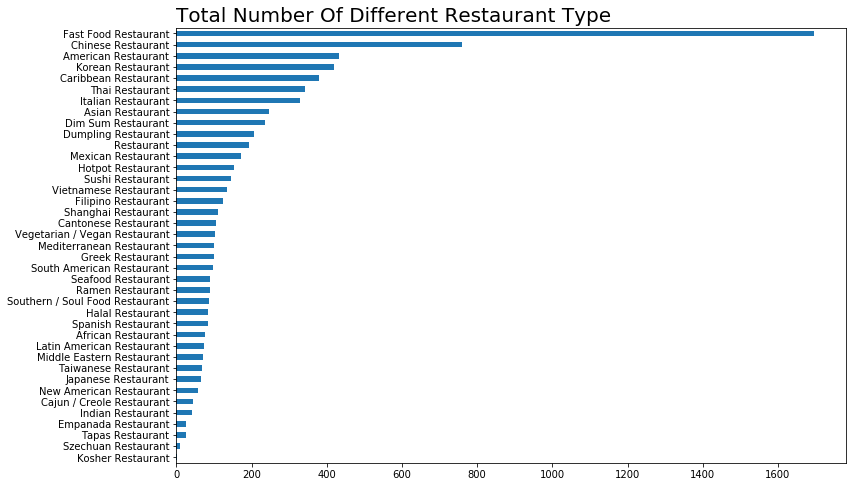

In [31]:
restaurant = df[
    df.columns[df.columns.str.contains("Restaurant", case=False)]
].sum()

restaurant.sort_values().plot(kind="barh", figsize=(12, 8))
plt.title("Total Number Of Different Restaurant Type", loc="left", fontsize=20)
plt.show()

In [33]:
school = df[["High School", "Elementary School"]].sum()

In [34]:
school

High School          4731
Elementary School      32
dtype: int64

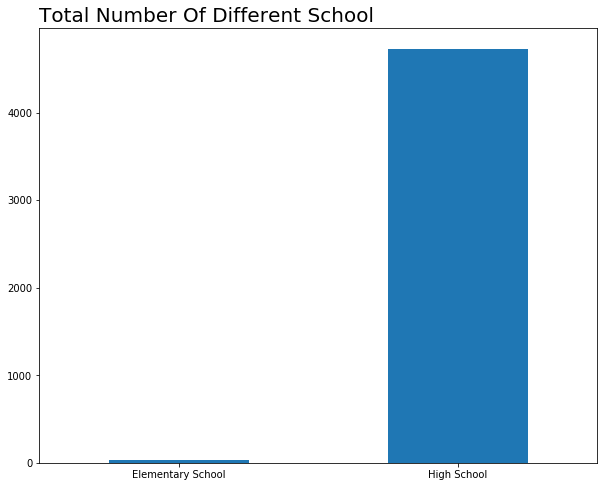

In [35]:
school.sort_values().plot(kind="bar", figsize=(10, 8), rot=0)
plt.title("Total Number Of Different School", loc="left", fontsize=20)
plt.show()

In [36]:
df["AllRestarant"] = df[
    df.columns[df.columns.str.contains("Restaurant", case=False)]
].sum(axis=1)

In [37]:
df["AllSchool"] = df[["High School", "Elementary School"]].sum(axis=1)

/home/jupyterlab/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


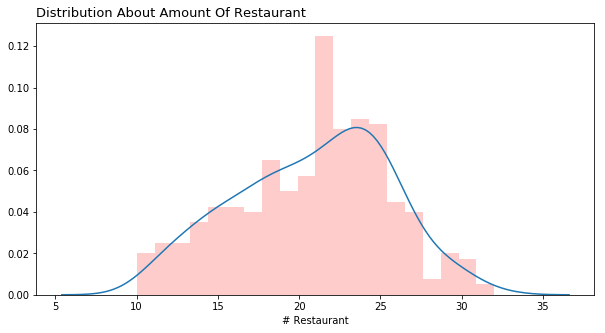

In [38]:
_, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df.AllRestarant, ax=ax, hist_kws={"color":"red", "alpha":.2}, bins=20)

ax.set_title("Distribution About Amount Of Restaurant", loc="left", fontsize=13)
ax.set_xlabel("# Restaurant")
plt.show()

We can find some information, like that the fast food restaurant is main type in the Queens center, and the second type is the Chinese restaurant. Top 3 restaurant:
* Fast Food Restaurant
* Chinese Restaurant
* American Restaurant

Besides, there are between 20 and 25 restaurants at most candidate location.

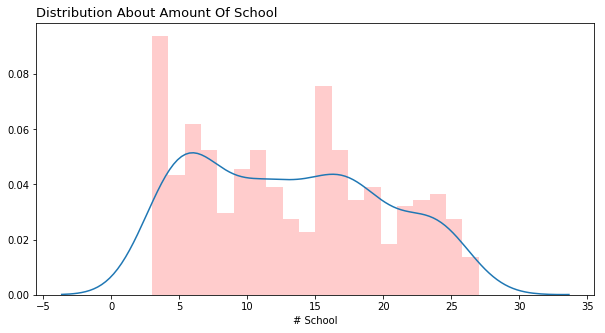

In [39]:
_, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df.AllSchool, ax=ax, hist_kws={"color":"red", "alpha":.2}, bins=20)

ax.set_title("Distribution About Amount Of School", loc="left", fontsize=13)
ax.set_xlabel("# School")
plt.show()

### School Information
There are two type of schools, elementary school and high school. And hight school is the major type. Most candidate location has less five schools.

## Map Information

In [41]:
foodlocation = []
for i in df["FoodInformation"]:
    if pd.notna(i):
        try:
            i = json.loads(i)
            foodlocation += i["Location"]
        except:
            foodlocation += i["Location"]

In [42]:
center

[40.7282239, -73.7948516]

In [60]:
map_init = folium.Map(location=center, zoom_start=13.48, tiles="CartoDB dark_matter")
folium.Marker(center, popup='Queens Food').add_to(map_init)
# # add markers to map
# label = '{}'.format(addr)
# label = folium.Popup(label, parse_html=True)
# # folium.Marker(center, popup=label).add_to(map_init)

for lat, lon, sc, ar in zip(df["Latitude"], df["Longitude"], df["AllSchool"], df["AllRestarant"]):
#     if sc != 0:
#         folium.CircleMarker([lat, lon], radius=sc * .2, fill=True, 
#                             fill_color="blue", fill_opacity=.3).add_to(map_init)
    if ar != 0:
        folium.CircleMarker([lat, lon], radius=ar * .2, fill=True, color="red",
                           fill_color="red", fill_opacity=.8).add_to(map_init)
#     label = 'School:{}\nRestaurant:{}'.format(sc, ar)
#     label = folium.Popup(label, parse_html=True)
#     folium.Marker([lat, lon], popup=label).add_to(map_init)

map_init

In [58]:
map_init = folium.Map(location=center, zoom_start=13.48, tiles="CartoDB dark_matter")
folium.Marker(center, popup='Queens Schools').add_to(map_init)
# # add markers to map
# label = '{}'.format(addr)
# label = folium.Popup(label, parse_html=True)
# # folium.Marker(center, popup=label).add_to(map_init)

for lat, lon, sc, ar in zip(df["Latitude"], df["Longitude"], df["AllSchool"], df["AllRestarant"]):
    if sc != 0:
        folium.CircleMarker([lat, lon], radius=sc * .2, fill=True, color="blue",
                            fill_color="blue", fill_opacity=.8).add_to(map_init)
#     if ar != 0:
#         folium.CircleMarker([lat, lon], radius=ar * .2, fill=True, color="red",
#                            fill_color="red", fill_opacity=.8).add_to(map_init)
#     label = 'School:{}\nRestaurant:{}'.format(sc, ar)
#     label = folium.Popup(label, parse_html=True)
#     folium.Marker([lat, lon], popup=label).add_to(map_init)

map_init

In [61]:
df.columns

Index(['Address', 'Latitude', 'Longitude', 'X', 'Y', 'Distance from center',
       'CategoryFood', 'CategorySchool', 'FoodInformation',
       'SchoolInformation', 'Thai Restaurant', 'Mediterranean Restaurant',
       'Cantonese Restaurant', 'Sushi Restaurant', 'Latin American Restaurant',
       'Mexican Restaurant', 'Southern / Soul Food Restaurant',
       'American Restaurant', 'Filipino Restaurant',
       'Cajun / Creole Restaurant', 'Korean Restaurant',
       'Fast Food Restaurant', 'Spanish Restaurant', 'Caribbean Restaurant',
       'Italian Restaurant', 'Vietnamese Restaurant', 'Taiwanese Restaurant',
       'Asian Restaurant', 'South American Restaurant', 'Ramen Restaurant',
       'Middle Eastern Restaurant', 'Seafood Restaurant', 'Hotpot Restaurant',
       'Shanghai Restaurant', 'Japanese Restaurant', 'Empanada Restaurant',
       'Greek Restaurant', 'Restaurant', 'Dim Sum Restaurant',
       'Kosher Restaurant', 'African Restaurant',
       'Vegetarian / Vegan Restaura

In [62]:
train_data = df.drop(["Address", "CategoryFood", "Latitude" ,
                      'Longitude', 'X', 'Y', 'Fast Food Restaurant',
                      "CategorySchool", "FoodInformation",
                      "SchoolInformation", 'High School'], axis=1).copy()

In [63]:
train_data.head(2)

,Distance from center,Thai Restaurant,Mediterranean Restaurant,Cantonese Restaurant,Sushi Restaurant,Latin American Restaurant,Mexican Restaurant,Southern / Soul Food Restaurant,American Restaurant,Filipino Restaurant,...,New American Restaurant,Chinese Restaurant,Tapas Restaurant,Indian Restaurant,Dumpling Restaurant,Halal Restaurant,Elementary School,Szechuan Restaurant,AllRestarant,AllSchool
0,5992.495307,0,0,0,2,1,2,1,0,0,...,0,5,0,0,0,0,0,0,26,8
1,5840.376700,0,0,0,2,1,2,1,0,0,...,0,4,0,0,0,1,0,0,24,7


## Scale the data
The feature `Distance from center` are large value, so we use the `StandardScaler` method to scale the value

In [64]:
from sklearn.preprocessing import Normalizer, normalize, StandardScaler, MinMaxScaler, minmax_scale

In [66]:
norm = StandardScaler()
train_data[["Distance from center", "AllRestarant"]] = \
    norm.fit_transform(train_data[["Distance from center", "AllRestarant"]])

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [67]:
train_data.head(2)

,Distance from center,Thai Restaurant,Mediterranean Restaurant,Cantonese Restaurant,Sushi Restaurant,Latin American Restaurant,Mexican Restaurant,Southern / Soul Food Restaurant,American Restaurant,Filipino Restaurant,...,New American Restaurant,Chinese Restaurant,Tapas Restaurant,Indian Restaurant,Dumpling Restaurant,Halal Restaurant,Elementary School,Szechuan Restaurant,AllRestarant,AllSchool
0,1.400281,0,0,0,2,1,2,1,0,0,...,0,5,0,0,0,0,0,0,1.098931,8
1,1.292965,0,0,0,2,1,2,1,0,0,...,0,4,0,0,0,1,0,0,0.673840,7


## Reduce Dimension
We can create the principle component.

In [68]:
from sklearn.decomposition import PCA

In [69]:
pca = PCA(n_components=6)
pca.fit(train_data)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [70]:
pca.explained_variance_ratio_

array([0.70486607, 0.09790623, 0.05607952, 0.03650603, 0.02465284,
       0.01479757])

In [71]:
def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n   %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

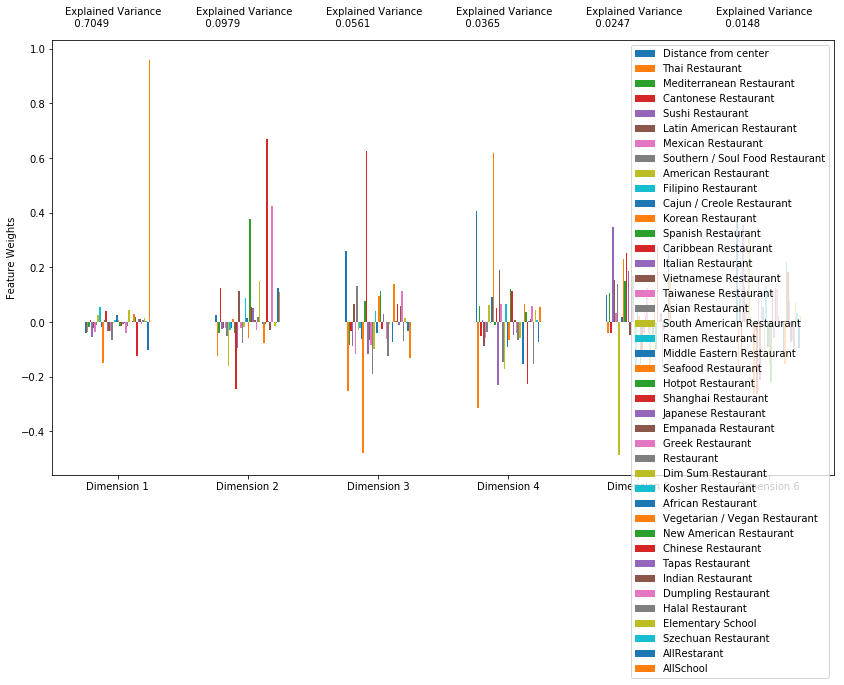

In [72]:
pca_result = pca_results(train_data, pca)

/home/jupyterlab/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


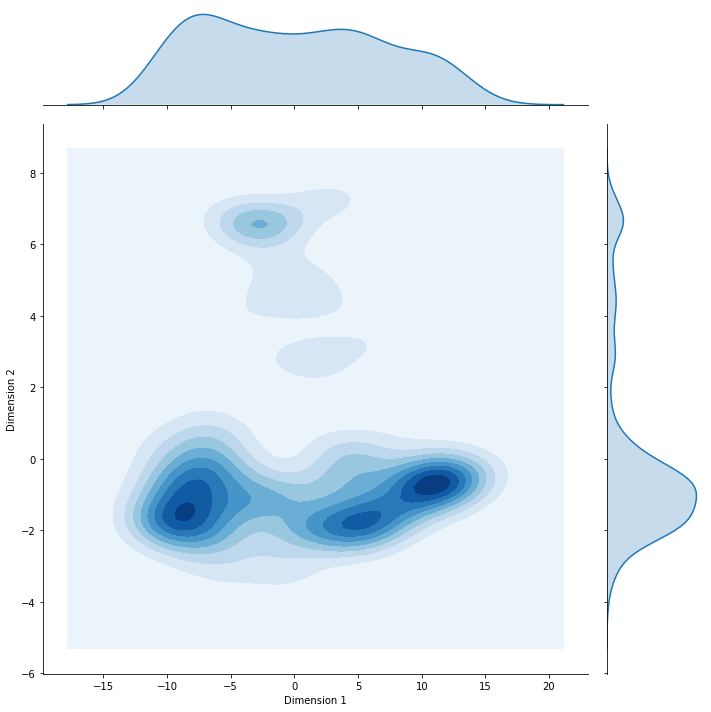

In [73]:

g = sns.JointGrid("Dimension 1", "Dimension 2", height=10, data=
                  pd.DataFrame(np.round(pca.transform(train_data), 4), 
                               columns = pca_result.index.values))
g = g.plot_joint(sns.kdeplot, cmap="Blues", shade=True)
g = g.plot_marginals(sns.kdeplot, shade=True)

## Create Cluster
We want to explore the number of cluster. So we use the KMeans algorithm to create model. Now we must check out how many clusters in the 364 candidate locations. In early step, we find that maybe there are four cluster about the two main principle.

In [74]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import numpy as np

In [75]:
from sklearn.model_selection import train_test_split

In [76]:
train, test = train_test_split(pca.transform(train_data)[:, :2], test_size=.02, random_state=42)

In [77]:
def create_cluster(data, n, validate_data=None):
    clusterer = KMeans(random_state=42, n_clusters=n)
    
    clusterer.fit(data)
    preds = clusterer.predict(data)

    # TODO：cluseter Center
    centers = clusterer.cluster_centers_

    # TODO：predict
    sample_preds = clusterer.predict(validate_data)

    # TODO：计算选择的类别的平均轮廓系数（mean silhouette coefficient）
    score = silhouette_score(data, preds)
    
    print("The %d clusters of KMeans, the score is %.3f" % (n, score))
    return clusterer, centers, preds, score, sample_preds

In [86]:
k = []
tem = []
final_score = 0
for i in range(2, 10):
    _, centers, preds, score, validate_preds = create_cluster(train, i, test)
    k.append(i)
    tem.append(score)
    if final_score == 0 or final_score <= score:
        final_score = score
        final_preds = preds
        final_centers = centers
        sample_preds = validate_preds

The 2 clusters of KMeans, the score is 0.558
The 3 clusters of KMeans, the score is 0.515
The 4 clusters of KMeans, the score is 0.568
The 5 clusters of KMeans, the score is 0.551
The 6 clusters of KMeans, the score is 0.559
The 7 clusters of KMeans, the score is 0.496
The 8 clusters of KMeans, the score is 0.481
The 9 clusters of KMeans, the score is 0.457


In [79]:
def cluster_results(reduced_data, preds, centers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions
    Adds cues for cluster centers and student-selected sample data
    '''

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, pd.DataFrame(reduced_data, 
                                                     columns=["Dimension 1", "Dimension 2"])], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

    # Plot transformed sample points 
    ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
               s = 150, linewidth = 4, color = 'black', marker = 'x');

    # Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\n \
        Transformed Sample Data Marked by Black Cross");


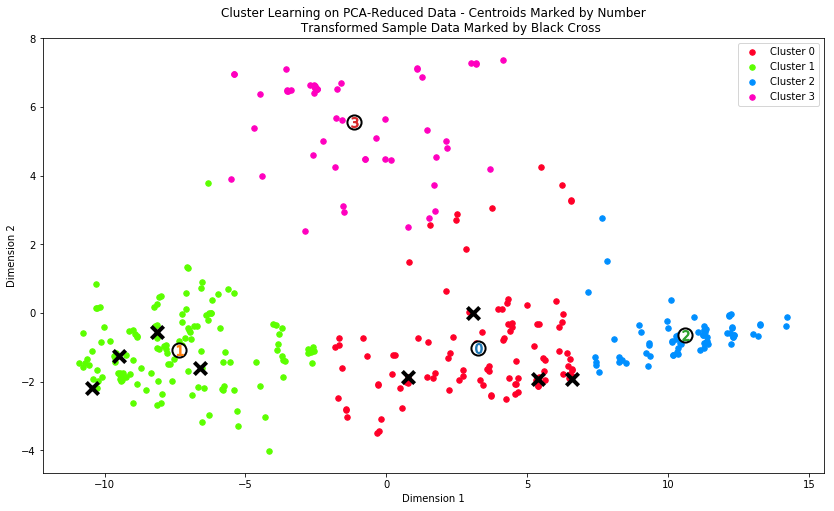

In [80]:
cluster_results(train, final_preds, final_centers, test)

In [81]:
kclusters = 4
clusterer = KMeans(n_clusters=kclusters, random_state=42)
cluster_labels = clusterer.fit_predict(pca.transform(train_data))
train_data["Cluster"] = cluster_labels

In [82]:
train_data.head(2)

,Distance from center,Thai Restaurant,Mediterranean Restaurant,Cantonese Restaurant,Sushi Restaurant,Latin American Restaurant,Mexican Restaurant,Southern / Soul Food Restaurant,American Restaurant,Filipino Restaurant,...,Chinese Restaurant,Tapas Restaurant,Indian Restaurant,Dumpling Restaurant,Halal Restaurant,Elementary School,Szechuan Restaurant,AllRestarant,AllSchool,Cluster
0,1.400281,0,0,0,2,1,2,1,0,0,...,5,0,0,0,0,0,0,1.098931,8,2
1,1.292965,0,0,0,2,1,2,1,0,0,...,4,0,0,0,1,0,0,0.673840,7,2


## Results and Discussion <a name="results"></a>

In [88]:
map_init = folium.Map(location= center, zoom_start=13, tiles="CartoDB dark_matter")
import matplotlib.colors as colors
# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(df['Latitude'], df['Longitude'], train_data['Cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=3,
#         popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_init)
       
map_init

In [84]:
df["Cluster"] = train_data["Cluster"]

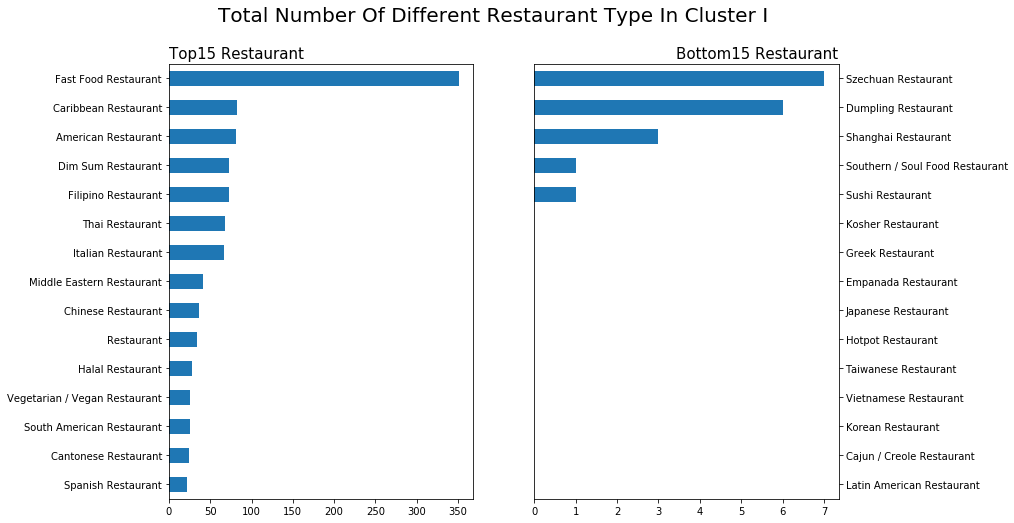

In [89]:
show_data = df.loc[train_data["Cluster"]== 0]
fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=1)
restaurant = show_data[
    show_data.columns[show_data.columns.str.contains("Restaurant", case=False)]
].sum()

restaurant.nlargest(15).sort_values().plot(kind="barh", ax=ax[0])
ax[0].set_title("Top15 Restaurant", loc="left", fontsize=15)
restaurant.nsmallest(15).plot(kind="barh", ax=ax[1])
ax[1].tick_params(labelleft=False, labelright=True, left=False, right=True)
ax[1].set_title("Bottom15 Restaurant", loc="right", fontsize=15)
fig.suptitle("Total Number Of Different Restaurant Type In Cluster I",  fontsize=20)
plt.show()

### Cluster I Candidate Location
* Fast Restaurant is main type
* Western Restaurants have the largest market
* Eastern Restaurants have the few market

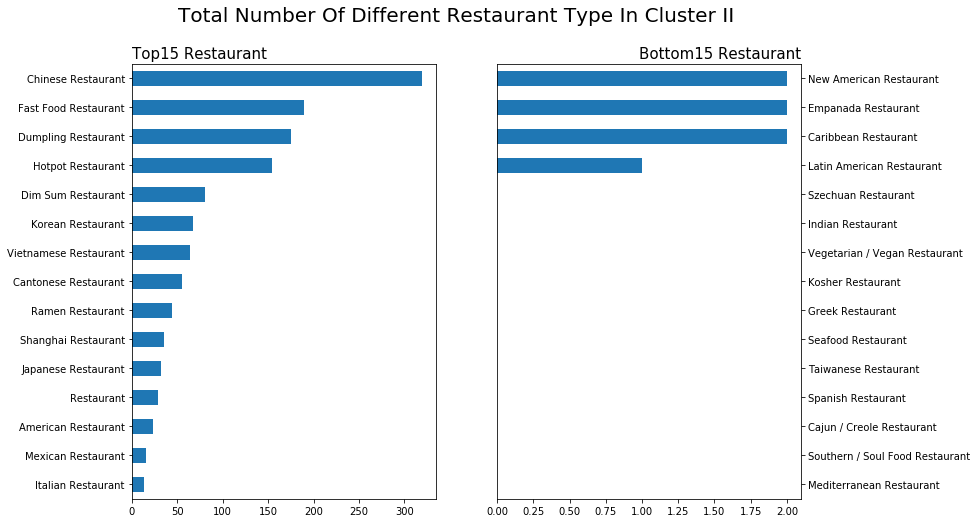

In [90]:
show_data = df.loc[train_data["Cluster"]== 1]
fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=1)
restaurant = show_data[
    show_data.columns[show_data.columns.str.contains("Restaurant", case=False)]
].sum()

restaurant.nlargest(15).sort_values().plot(kind="barh", ax=ax[0])
ax[0].set_title("Top15 Restaurant", loc="left", fontsize=15)
restaurant.nsmallest(15).plot(kind="barh", ax=ax[1])
ax[1].tick_params(labelleft=False, labelright=True, left=False, right=True)
ax[1].set_title("Bottom15 Restaurant", loc="right", fontsize=15)
fig.suptitle("Total Number Of Different Restaurant Type In Cluster II", fontsize=20)
plt.show()


### Cluster II Candidate Location
* Chinese Restaurant is main type
* Asian Restaurants have the largest market, like Chinese Breakfast restaurant
* Western Restaurants have the few market

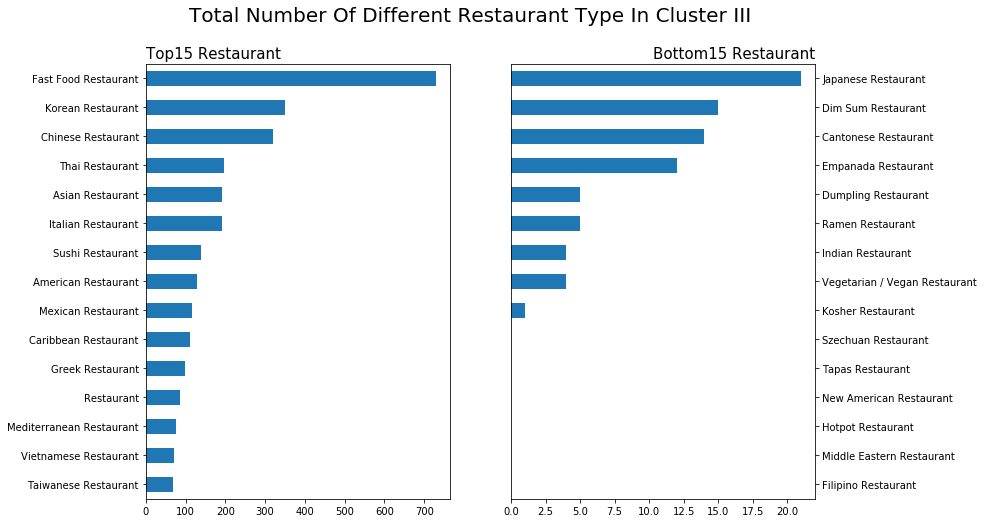

In [91]:
show_data = df.loc[train_data["Cluster"]== 2]
fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=1)
restaurant = show_data[
    show_data.columns[show_data.columns.str.contains("Restaurant", case=False)]
].sum()

restaurant.nlargest(15).sort_values().plot(kind="barh", ax=ax[0])
ax[0].set_title("Top15 Restaurant", loc="left", fontsize=15)
restaurant.nsmallest(15).plot(kind="barh", ax=ax[1])
ax[1].tick_params(labelleft=False, labelright=True, left=False, right=True)
ax[1].set_title("Bottom15 Restaurant", loc="right", fontsize=15)
fig.suptitle("Total Number Of Different Restaurant Type In Cluster III", fontsize=20)
plt.show()

### Cluster III Candidate Location
* Fast Food Restaurant is main type
* The candidate location has mixture restaurant type.Asian Restaurants and western restaurant are same important type
* the Asian restaurant is lack of variety. The candidate location is a good choice to open an Asian restaurant. Maybe the Chinese Breakfast restaurant is a good idea

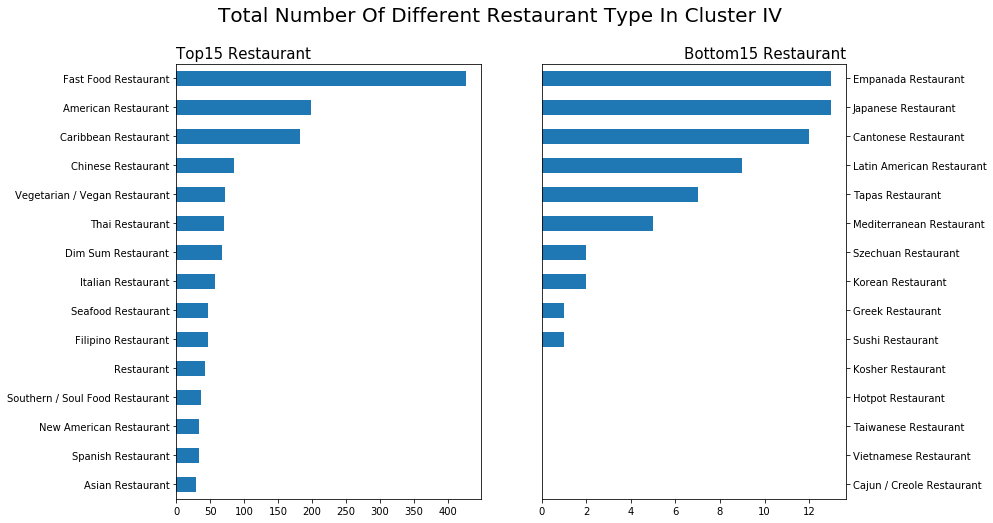

In [92]:
show_data = df.loc[train_data["Cluster"]== 3]
fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=1)
restaurant = show_data[
    show_data.columns[show_data.columns.str.contains("Restaurant", case=False)]
].sum()

restaurant.nlargest(15).sort_values().plot(kind="barh", ax=ax[0])
ax[0].set_title("Top15 Restaurant", loc="left", fontsize=15)
restaurant.nsmallest(15).plot(kind="barh", ax=ax[1])
ax[1].tick_params(labelleft=False, labelright=True, left=False, right=True)
ax[1].set_title("Bottom15 Restaurant", loc="right", fontsize=15)
fig.suptitle("Total Number Of Different Restaurant Type In Cluster IV", fontsize=20)
plt.show()

### Cluster IV Candidate Location
* Fast Food Restaurant is main type
* The candidate location has mixture restaurant type.Asian Restaurants and western restaurant are same important type
* the Asian restaurant is lack of variety. The candidate location is a good choice to open an Asian restaurant. But the southeastern Asian restaurant is not a good idea